<a href="https://colab.research.google.com/github/vaibhav2903/deepfakeDetection/blob/main/Deepfake_Detection_RNN_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

drive.mount('/content/drive/')
file_path_X = '/content/drive/MyDrive/X_data.npy'
np_data_X = np.load(file_path_X)

Mounted at /content/drive/


In [ ]:
import numpy as np
file_path_Y = '/content/drive/MyDrive/Y_data.npy'
np_data_Y = np.load(file_path_Y)

In [ ]:
np_data_X.size

2902330368

In [ ]:
np_data_Y.size

19281

array([[[137, 130, 133],
        [135, 128, 131],
        [131, 123, 127],
        ...,
        [198, 196, 202],
        [186, 184, 190],
        [181, 179, 185]],

       [[136, 129, 132],
        [134, 127, 130],
        [131, 124, 127],
        ...,
        [199, 197, 203],
        [188, 186, 192],
        [184, 182, 187]],

       [[133, 126, 129],
        [133, 126, 129],
        [132, 125, 129],
        ...,
        [201, 199, 205],
        [193, 191, 197],
        [189, 187, 193]],

       ...,

       [[251, 249, 248],
        [251, 249, 248],
        [250, 248, 247],
        ...,
        [215, 210, 216],
        [215, 211, 216],
        [216, 211, 216]],

       [[251, 249, 248],
        [250, 249, 248],
        [250, 248, 247],
        ...,
        [211, 206, 211],
        [212, 207, 211],
        [212, 208, 210]],

       [[251, 249, 248],
        [250, 248, 247],
        [249, 248, 247],
        ...,
        [209, 204, 209],
        [210, 205, 208],
        [211, 206, 208]]], dtype=uint8)
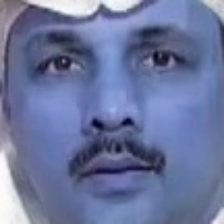

In [ ]:
np_data_X[0]

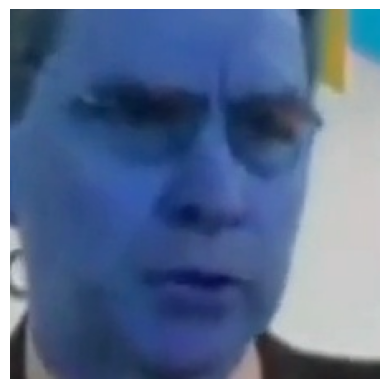

In [ ]:
plt.imshow(np_data_X[1119])
plt.axis('off')  # to turn off axis labels
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load pre-trained VGG16 model without the classification layer
VGG_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
def predict_batch(batch):
    return VGG_model.predict(batch)

# Splitting data into batches
batch_size = 1000  # Adjust batch size according to your data and resource constraints
batches = [np_data_X[i:i + batch_size] for i in range(0, len(np_data_X), batch_size)]

In [ ]:
# Using ThreadPoolExecutor for parallel execution
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=5) as executor:  # Adjust max_workers as needed
    results = list(executor.map(predict_batch, batches))

9/9 [==============================] - 3s 402ms/step


In [ ]:
# Combining results
features = np.concatenate(results)

In [ ]:
# # features = VGG_model.predict(np_data_X)
# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
features.shape

(19281, 7, 7, 512)

In [ ]:
features_reshaped = features.reshape(features.shape[0], 49, 512)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(49, 512)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features_reshaped, np_data_Y, test_size=0.2, random_state=42)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([11716,  4148,  2894, ...,  5390,   860, 15795])

In [ ]:
history = model.fit(features_train, labels_train, epochs=24, batch_size=32, validation_split=0.2)

Epoch 1/24
386/386 [==============================] - 5s 12ms/step - loss: 0.0309 - accuracy: 0.9886 - val_loss: 0.2290 - val_accuracy: 0.9374
Epoch 2/24
386/386 [==============================] - 4s 10ms/step - loss: 0.0248 - accuracy: 0.9912 - val_loss: 0.2441 - val_accuracy: 0.9345
Epoch 3/24
386/386 [==============================] - 4s 10ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 0.2740 - val_accuracy: 0.9313
Epoch 4/24
386/386 [==============================] - 4s 10ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.2369 - val_accuracy: 0.9274
Epoch 5/24
386/386 [==============================] - 4s 10ms/step - loss: 0.0219 - accuracy: 0.9912 - val_loss: 0.2620 - val_accuracy: 0.9335
Epoch 6/24
386/386 [==============================] - 4s 10ms/step - loss: 0.0216 - accuracy: 0.9919 - val_loss: 0.2736 - val_accuracy: 0.9342
Epoch 7/24
386/386 [==============================] - 4s 10ms/step - loss: 0.0176 - accuracy: 0.9940 - val_loss: 0.2801 - val_accuracy: 0.9300

In [ ]:
predictions_prob = model.predict(features_test)
predictions = (predictions_prob > 0.5).astype("int32")

121/121 [==============================] - 1s 4ms/step


In [ ]:
f1 = f1_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")

F1 Score: 0.9292107404393817
Precision: 0.9543175487465181


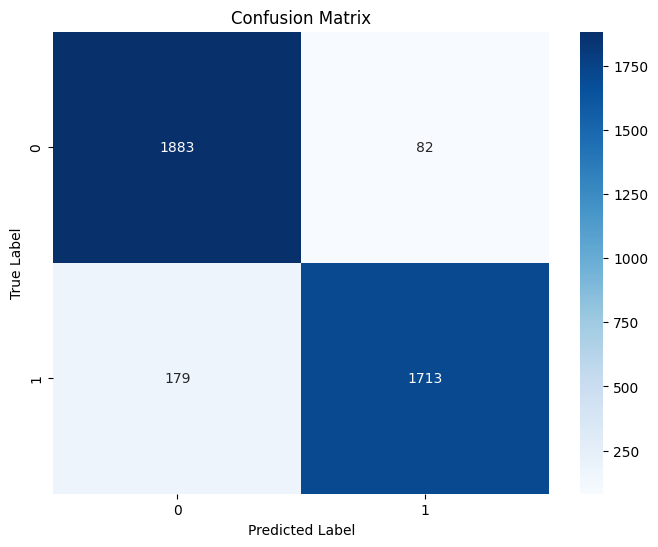

In [ ]:
cm = confusion_matrix(labels_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(features_test, labels_test)
print(f"Test accuracy: {test_accuracy}")

121/121 [==============================] - 1s 4ms/step - loss: 0.1960 - accuracy: 0.9414
Test accuracy: 0.9414052367210388


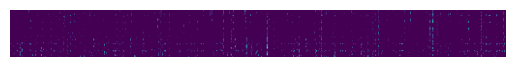

In [ ]:
plt.imshow(features_train[1])
plt.axis('off')  # to turn off axis labels
plt.show()

In [ ]:
import pdb
def vgg_lstm_predict(images):
    features = []
    for img in images:
        img_preprocessed = preprocess_input(img)
        img_features = VGG_model.predict(np.array([img_preprocessed]))
        img_features_flattened = img_features.flatten()
        #pdb.set_trace()
        # Reshape features to match LSTM input shape
        img_features_reshaped = img_features_flattened.reshape(49, 512)
        features.append(img_features_reshaped)

    # Convert to numpy array for batch prediction
    features_array = np.array(features)
    #pdb.set_trace()

    # Predict with LSTM model
    predictions = model.predict(features_array)

    return predictions

In [ ]:
##Explainer

from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [ ]:
np_data_X[1119].shape

(224, 224, 3)

In [ ]:
explanation = explainer.explain_instance(np_data_X[2000], vgg_lstm_predict, top_labels=2)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


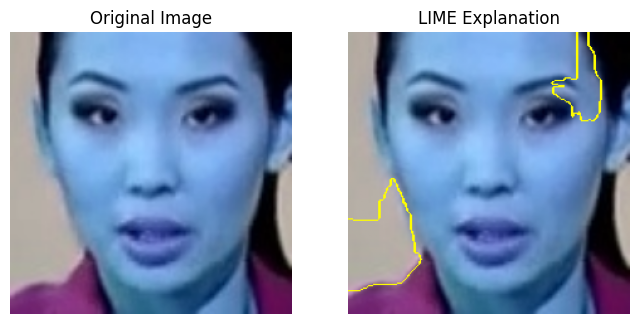

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
image,mask= explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=False)
# Displaying the original image and the explanation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Original image
ax1.imshow(image)
ax1.set_title('Original Image')
ax1.axis('off')

# Image with mask
ax2.imshow(mark_boundaries(image, mask))
ax2.set_title('LIME Explanation')
ax2.axis('off')

plt.show()

In [ ]:
np_data_Y[2000]

0

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(labels_test, predictions_prob)
roc_auc = roc_auc_score(labels_test, predictions_prob)

In [ ]:
roc_auc

0.9867344221551572

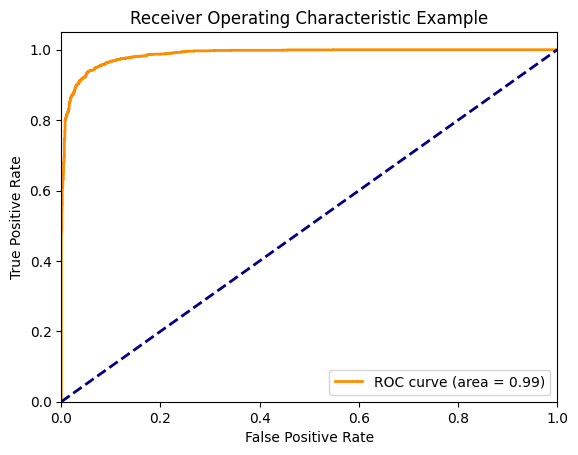

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('rnn_cnn.keras')

In [ ]:
features_reshaped = tf.reshape(features, (-1, 49, 512))

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(features_reshaped)
    predictions = model(features_reshaped)  # Make sure combined_model expects the reshaped input
    predicted_class = tf.argmax(predictions, axis=1)
    loss = tf.reduce_max(predictions, axis=1)

In [ ]:
gradients = tape.gradient(loss, features_reshaped)

In [ ]:
gradients_reshaped = tf.reshape(gradients, (-1, 7, 7, 512))

In [ ]:
test_data_point = features_reshaped[1]
test_data_point = tf.expand_dims(test_data_point, axis=0)
with tf.GradientTape() as tape:
    tape.watch(test_data_point)
    predictions = model(test_data_point)
    loss = tf.reduce_max(predictions)
gradients = tape.gradient(loss, test_data_point)

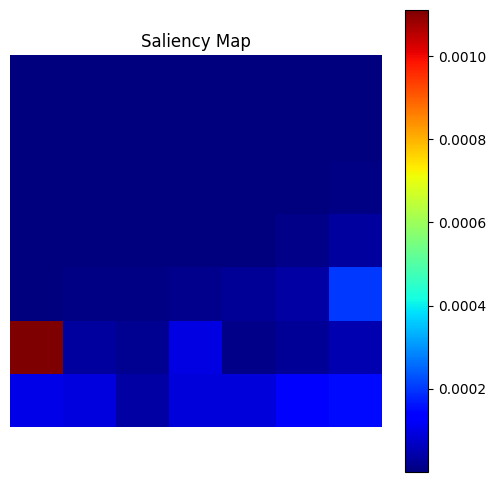

In [ ]:
gradients_reshaped = tf.reshape(gradients, (-1, 7, 7, 512))
saliency_map = tf.reduce_mean(tf.abs(gradients_reshaped), axis=-1)

plt.figure(figsize=(6, 6))
plt.imshow(saliency_map[0], cmap='jet')
plt.colorbar()
plt.title('Saliency Map')
plt.axis('off')
plt.show()